# IT1244 Project

## Import Libraries

In [139]:
import re as re
import heapq as heapq
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MultiLabelBinarizer, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import random as random
from sklearn.preprocessing import StandardScaler
import pyarrow as pa
import pyarrow.parquet as pq
from sklearn.decomposition import PCA

### Import Bert Encoders

In [2]:
import torch as torch
from transformers import BertModel
from transformers import BertTokenizer, BertTokenizerFast

### Testing Bert Encoding

In [3]:

# Load tokenizer and model
model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Encode sentences
sentence1 = "This is an example sentence with change negative."
inputs1 = tokenizer(sentence1, return_tensors="pt")

sentence2 = "This is an example sentence with change upset."
inputs2 = tokenizer(sentence2, return_tensors="pt")

sentence3 = "This is an example sentence with change happy."
inputs3 = tokenizer(sentence3, return_tensors="pt")

# Get embeddings
with torch.no_grad():
    outputs1 = model(**inputs1)
    outputs2 = model(**inputs2)
    outputs3 = model(**inputs3)

# Extract [CLS] token embedding (sentence-level representation)
Vector_X = outputs1.last_hidden_state[:, 0, :]
Vector_Y = outputs2.last_hidden_state[:, 0, :]
Vector_Z = outputs3.last_hidden_state[:, 0, :]

In [4]:
print(float(cosine_similarity(Vector_X, Vector_Y)[0][0]))
print(float(cosine_similarity(Vector_X, Vector_Z)[0][0]))

0.9878990054130554
0.982489287853241


In [5]:
def bert_encode(sentence):
    inputs = tokenizer(sentence, return_tensors="pt")
    with torch.no_grad():
        output = model(**inputs)
    return output.last_hidden_state[:, 0, :]


We can see that the closer concepts are have higher cosine similiarity

## Data Importing

In [6]:
tweets = pd.read_csv("../Data/Raw/Tweets.csv")
tweets.head()

,airline_sentiment,sentiment_confidence,text
0,neutral,1.0000,@VirginAmerica What @dhepburn said.
1,positive,0.3486,@VirginAmerica plus you've added commercials t...
2,neutral,0.6837,@VirginAmerica I didn't today... Must mean I n...
3,negative,1.0000,@VirginAmerica it's really aggressive to blast...
4,negative,1.0000,@VirginAmerica and it's a really big bad thing...


In [7]:
tweets.shape

(14639, 3)

In [8]:
tweets["text"][1]

"@VirginAmerica plus you've added commercials to the experience... tacky."

### Code starts here

## Data Cleaning

In [9]:
def at_filter(text):
    return re.sub(r"@\w+", "", text)

def alpha_filter(text):
    return re.sub(r'[^A-Za-z ]', '', text)

In [10]:
tweets["text"] = tweets["text"].apply(lambda x: at_filter(x))
tweets["text"] = tweets["text"].apply(lambda x: alpha_filter(x))

In [11]:
tweets

,airline_sentiment,sentiment_confidence,text
0,neutral,1.0000,What said
1,positive,0.3486,plus youve added commercials to the experienc...
2,neutral,0.6837,I didnt today Must mean I need to take anothe...
3,negative,1.0000,its really aggressive to blast obnoxious ente...
4,negative,1.0000,and its a really big bad thing about it
...,...,...,...
14634,positive,0.3487,thank you we got on a different flight to Chi...
14635,negative,1.0000,leaving over minutes Late Flight No warnings...
14636,neutral,1.0000,Please bring American Airlines to BlackBerry
14637,negative,1.0000,you have my money you change my flight and do...


In [12]:
tweets.to_csv("../Data/Cleaned/CleanTweets.csv")

## Data transformation

#### Map Tweets into Vectors in R^n

In [ ]:
sentence_vectors = tweets["text"].apply(lambda x: bert_encode(x))
data = np.array(list(map(lambda x: x[0], sentence_vectors)))

#### Store Data as a CSV so don't need to re-encode every time

In [ ]:
#data_frame = pd.DataFrame(data)
#data_frame.to_txt("../Data/Cleaned/BERT_Vectors.csv")

In [ ]:
#pq.write_table(table, "../Data/Cleaned/BERT_Vectors.oarquet")

#### BERT Encodings can be found in data below

In [17]:
Bert_Encoded_Text = pd.read_parquet("../Data/Cleaned/BERT_Vectors.oarquet")
data = Bert_Encoded_Text.to_numpy()

In [20]:
data.shape

(14639, 768)

### K-means using personal implementation

In [22]:
def cos_distance(x1, x2):
    '''
    x1: numpy array, shape = [D]
    x2: numpy array, shape = [D]
    RETURN
        dist: float value
    '''
    #dist = np.sqrt(np.dot(x1-x2,x1-x2))
    x1_length = np.dot(x1, x1)
    x2_length = np.dot(x2, x2)
    cosine = np.dot(x1, x2)/(x1_length*x2_length)
    dist = np.arccos(cosine)/np.arccos(-1)

    ## end
    return dist

In [23]:
def closestCentroid(input_vector, centroid_dict):
    '''
    coordinates_x: numpy array, shape = [D]
    coordinates_centroid: dictionary, key = int, value = numpy array of shape [D]
    RETURN
        closest_centroid: int value
    '''
    closest_centroid = None

    ## start your code here
    smallest_dist = 10**10

    for key in centroid_dict:
        curr_centroid_vector = centroid_dict[key]
        curr_centroid_vector = curr_centroid_vector.reshape(-1)
        curr_dist = cos_distance(curr_centroid_vector, input_vector)
        
        if (curr_dist < smallest_dist):
            closest_centroid = key
            smallest_dist = curr_dist
    
    ## end
    return closest_centroid

When using arccos(cosine_similarity)/π as the distance metric, the standard arithmetic mean used in k-means won’t work correctly because it doesn’t preserve unit directionality. 

Instead, we need to compute the centroid in a way that maintains the directional nature of the embeddings. 

The best approach is to use the normalized mean vector.

In [24]:
def compute_new_centroid(cluster_vectors):
    if len(cluster_vectors) == 0:
        return None  # Handle empty clusters
    
    cluster_vectors = [vec / np.linalg.norm(vec) for vec in cluster_vectors] 
    
    mean_vector = np.mean(cluster_vectors, axis=0).reshape(-1)  # Step 1: Compute the mean vector
    norm = np.linalg.norm(mean_vector)  # Step 2: Compute its norm
    
    if norm == 0:
        return np.zeros_like(mean_vector)  # Edge case: if the norm is 0, return a zero vector
    
    return mean_vector / norm  # Step 3: Normalize to get unit vector

In [114]:
def KMeansClustering(X, initial_centroids, k, n, tolerance=1e-20):
    '''
    X: numpy array, shape = [N, D]
    index_centroids: list, shape = k
    k: int value
    n: int value
    RETURN
        repartition: dictionary, key = int, value = numpy array of shape [number of points in cluster, D]
        coordinates: dictionary, key = int, value = numpy array of shape [D]
    '''


    repartition, centroids,  = None, dict()
    ## start your code here
    # Initialise your first centroids
    for i in range(k):
        centroids[i] = initial_centroids[i]
        
    # Define stopping criterion
    for i in range(n):
        # Initialise new dictionaries for repartition and coordinates
        repartition = dict()
        for i in range(k):
            repartition[i] = []
            
        # Assign all the points to the closest cluster centroid
        for vector in X:
            repartition[closestCentroid(vector, centroids)].append(vector)

        
        # Compute new centroids
        new_centroids = {}
        for cluster_key in repartition:
            new_centroids[cluster_key] = compute_new_centroid(repartition[cluster_key])
        
        # Check for early stopping (convergence)
        centroid_changes = [np.linalg.norm(new_centroids[cluster_key] - centroids[cluster_key]) for cluster_key in centroids]
        max_change = max(centroid_changes)

        # If the max change in centroids is smaller than the tolerance, stop early
        if max_change < tolerance:
            print(f"Converged early after {i+1} iterations.")
            return repartition, centroids
        
        # Update centroids for the next iteration
        centroids = new_centroids
        
    
    ## end
    return repartition, centroids

### K-Means using sklearn

In [27]:
def sklearnKmeans(X, k, m):
    '''
    X: numpy array, shape = [N, D]
    k: int value
    m: int value
    RETURN
        position: numpy array, shape = [N]
        centers: numpy array, shape = [k, D]
    '''
    position, centers = None, None
    ## start your code here
    kmeans = KMeans(n_clusters=k, init="random", n_init=1, max_iter=m).fit(X)
    position, centers = kmeans.predict(X), kmeans.cluster_centers_
    ## end
    return position, centers

In [28]:
def sklearnKmeans_plus(X, k, m):
    '''
    X: numpy array, shape = [N, D]
    k: int value
    m: int value
    RETURN
        position: numpy array, shape = [N]
        centers: numpy array, shape = [k, D]
    '''
    position, centers = None, None
    ## start your code here
    kmeans = KMeans(n_clusters=k, init="k-means++", n_init=1, max_iter=m).fit(X)
    position, centers = kmeans.predict(X), kmeans.cluster_centers_
    ## end
    return position, centers

## Modelling the Data

In [29]:
def euclideanDist(x1, x2):
    '''
    x1: numpy array, shape = [D]
    x2: numpy array, shape = [D]
    RETURN
        dist: float value
    '''
    dist = np.sqrt(np.dot(x1-x2,x1-x2))
    ## start your code here
    
    
    ## end
    return dist

In [30]:
def closest_to_Centroid(clusters, centroids, distance):

    cluster_representatives = dict()
    for cluster in clusters.keys():
        cluster_representatives[cluster] = []

    for cluster in clusters.keys():
        curr_centroid = centroids[cluster]
        smallest_dist = 10**10
        closest_datapoint = clusters[cluster][0]

        for vector in clusters[cluster]:
            curr_dist = distance(vector, curr_centroid)
            if (curr_dist < smallest_dist):
                closest_datapoint = vector
                smallest_dist = curr_dist
        
        cluster_representatives[cluster] = closest_datapoint
        
    ## end

    return cluster_representatives

### Initial attempt using SK-Learn Library

In [33]:
position, centers = sklearnKmeans(data, 3, 10000)

In [34]:
clusters = {0:[], 1:[], 2:[]}
N = len(position)

for index in range(N):
    clusters[position[index]].append(data[index])

cluster_representatives = closest_to_Centroid(clusters, centers, euclideanDist)
cluster_rep_indexes = [np.where(data == rep)[0][0] for rep in cluster_representatives.values()]

# labelling the centroids to test accuracy
possible_labels = ["negative", "neutral", "positive"]
possible_clusters = [0, 1, 2]
labels = dict()

for cluster in possible_clusters:
    labels[cluster] = list(tweets["airline_sentiment"][cluster_rep_indexes])[cluster] 

predicted_sentiments = list(map(lambda x: labels[x], position))

accuracy = np.mean(tweets["airline_sentiment"] ==  predicted_sentiments)
print(f"accuracy is {np.round(accuracy*100, 2)}%")

accuracy is 39.7%


Accuracy achieved in First attempt is ≈ 39.70%

### Second attempt using SK-Learn Library (K-Means++)

In [39]:
position, centers = sklearnKmeans_plus(data, 3, 10000)

In [40]:
clusters = {0:[], 1:[], 2:[]}
N = len(position)

for index in range(N):
    clusters[position[index]].append(data[index])

cluster_representatives = closest_to_Centroid(clusters, centers, euclideanDist)
cluster_rep_indexes = [np.where(data == rep)[0][0] for rep in cluster_representatives.values()]

# labelling the centroids to test accuracy
possible_labels = ["negative", "neutral", "positive"]
possible_clusters = [0, 1, 2]
labels = dict()

for cluster in possible_clusters:
    labels[cluster] = list(tweets["airline_sentiment"][cluster_rep_indexes])[cluster] 

predicted_sentiments = list(map(lambda x: labels[x], position))

accuracy = np.mean(tweets["airline_sentiment"] ==  predicted_sentiments)
print(f"accuracy is {np.round(accuracy*100, 2)}%")

accuracy is 40.08%


Accuracy achieved in Second attempt is ≈ 40.08%

### Third Attempt using own K-Means Clustering algorithm

In [ ]:
initial_centroids = [np.array(data[random.randint(0, len(data) - 1)]) for i in range(3)]
clusters2, centers2 = KMeansClustering(data, initial_centroids, 3, 500)

Converged early after 3 iterations.


In [64]:
clusters2 = {0:[], 1:[], 2:[]}
N = len(position)

for index in range(N):
    clusters2[position[index]].append(data[index])

cluster_representatives2 = closest_to_Centroid(clusters2, centers2, cos_distance)
cluster_rep_indexes2 = [np.where(data == rep)[0][0] for rep in cluster_representatives2.values()]

# labelling the centroids to test accuracy
possible_labels = ["negative", "neutral", "positive"]
possible_clusters = [0, 1, 2]
labels2 = dict()

for cluster in possible_clusters:
    labels2[cluster] = list(tweets["airline_sentiment"][cluster_rep_indexes2])[cluster] 

predicted_sentiments2 = list(map(lambda x: labels2[x], position))

In [65]:
accuracy2 = np.mean(tweets["airline_sentiment"] ==  predicted_sentiments2)
print(f"accuracy is {np.round(accuracy2*100, 2)}%")

accuracy is 56.07%


Accuracy achieved in Third attempt is ≈ 56.07%

### Fourth Attempt using own K-Means++ Clustering algorithm

In [119]:
def centroid_initalizer(data, k, distance_func):
    
    n_samples = data.shape[0]
    # Step 1: Choose the first centroid randomly
    first_index = random.randint(0, n_samples - 1)
    centroids = [data[first_index]]
    
    for _ in range(1, k):
        # Compute the minimum distance to any chosen centroid
        distances = np.array([min(distance_func(x, c) for c in centroids) for x in data])
        
        # Normalize distances to form a probability distribution
        probabilities = distances / distances.sum()
        
        # Select next centroid based on weighted probability distribution
        next_index = np.random.choice(n_samples, p=probabilities)
        centroids.append(data[next_index])
    
    return centroids

In [131]:
initial_centroids = centroid_initalizer(data, 3, cos_distance)
clusters2, centers2 = KMeansClustering(data, initial_centroids, 3, 500)

Converged early after 3 iterations.


In [132]:
clusters2 = {0:[], 1:[], 2:[]}
N = len(position)

for index in range(N):
    clusters2[position[index]].append(data[index])

cluster_representatives2 = closest_to_Centroid(clusters2, centers2, cos_distance)
cluster_rep_indexes2 = [np.where(data == rep)[0][0] for rep in cluster_representatives2.values()]

# labelling the centroids to test accuracy
possible_labels = ["negative", "neutral", "positive"]
possible_clusters = [0, 1, 2]
labels2 = dict()

for cluster in possible_clusters:
    labels2[cluster] = list(tweets["airline_sentiment"][cluster_rep_indexes2])[cluster] 

predicted_sentiments2 = list(map(lambda x: labels2[x], position))

In [133]:
accuracy2 = np.mean(tweets["airline_sentiment"] ==  predicted_sentiments2)
print(f"accuracy is {np.round(accuracy2*100, 2)}%")

accuracy is 56.07%


Accuracy achieved in Fourth attempt is ≈ 56.07%

## Fifth Attempt

In [ ]:
# 1000 Random Seedings
results = dict()

for i in range(100):
    initial_centroids = centroid_initalizer(data, 3, cos_distance)
    clusters2, centers2 = KMeansClustering(data, initial_centroids, 3, 500)

    clusters2 = {0:[], 1:[], 2:[]}
    N = len(position)

    for index in range(N):
        clusters2[position[index]].append(data[index])

    cluster_representatives2 = closest_to_Centroid(clusters2, centers2, cos_distance)
    cluster_rep_indexes2 = [np.where(data == rep)[0][0] for rep in cluster_representatives2.values()]

    # labelling the centroids to test accuracy
    possible_labels = ["negative", "neutral", "positive"]
    possible_clusters = [0, 1, 2]
    labels2 = dict()

    for cluster in possible_clusters:
        labels2[cluster] = list(tweets["airline_sentiment"][cluster_rep_indexes2])[cluster] 

    predicted_sentiments2 = list(map(lambda x: labels2[x], position))

    accuracy2 = np.mean(tweets["airline_sentiment"] ==  predicted_sentiments2)
    results[i] = (accuracy2, (clusters2, centers2))

### Think of new ways to improve

#### PCA Analysis

In [138]:
scaler = StandardScaler()
bert_vectors_std = scaler.fit_transform(Bert_Encoded_Text)  # Shape: (N, 768)

In [148]:
# Choose the number of components
n_components = 300 # Example: Reduce to 50 dimensions
pca = PCA(n_components=n_components)

bert_pca = pca.fit_transform(bert_vectors_std)  # Shape: (N, 50)

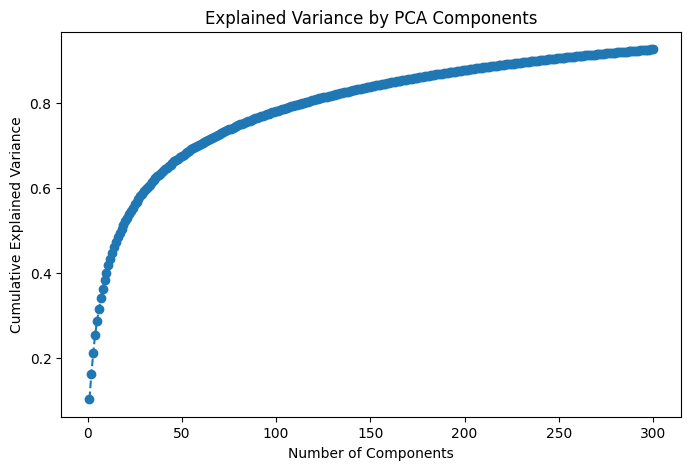

In [149]:
import matplotlib.pyplot as plt

explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.show()


In [150]:
n_components_optimal = np.argmax(explained_variance >= 0.95) + 1
print(f"Optimal number of components: {n_components_optimal}")

Optimal number of components: 1


In [151]:
initial_centroids = centroid_initalizer(bert_pca, 3, cos_distance)
clusters2, centers2 = KMeansClustering(bert_pca, initial_centroids, 3, 500)

Converged early after 3 iterations.


In [152]:
clusters2 = {0:[], 1:[], 2:[]}
N = len(position)

for index in range(N):
    clusters2[position[index]].append(bert_pca[index])

cluster_representatives2 = closest_to_Centroid(clusters2, centers2, cos_distance)
cluster_rep_indexes2 = [np.where(bert_pca == rep)[0][0] for rep in cluster_representatives2.values()]

# labelling the centroids to test accuracy
possible_labels = ["negative", "neutral", "positive"]
possible_clusters = [0, 1, 2]
labels2 = dict()

for cluster in possible_clusters:
    labels2[cluster] = list(tweets["airline_sentiment"][cluster_rep_indexes2])[cluster] 

predicted_sentiments2 = list(map(lambda x: labels2[x], position))

In [153]:
accuracy2 = np.mean(tweets["airline_sentiment"] ==  predicted_sentiments2)
print(f"accuracy is {np.round(accuracy2*100, 2)}%")

accuracy is 56.07%
